In [2]:
%matplotlib inline
from matplotlib import style

import matplotlib.pyplot as plt

# dependencies for styling
# Can also use ggplot2 reference https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
plt.style.use('fivethirtyeight')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

import seaborn as sns

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

# existing functions within sqlalchemy 
from sqlalchemy import create_engine, func, inspect, asc, desc

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Create inspector to view .sqlite file - or any other connected engine
inspector = inspect(engine)

In [11]:
# method of exploring the data within an engine
# call inspector and use get_columns() to view columns
# must be called pythonically

# measurement data inspection - create callable list of column names to refer back to and inspect datatypes
measurement_columns = []

measurement_ins = inspector.get_columns('measurement')
for column in measurement_ins:
    measurement_columns.append(column['name'])
    print(column['name'], column['type'])
    
measurement_columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


['id', 'station', 'date', 'prcp', 'tobs']

In [12]:
# station data inspection - create a callable list of column names to refer back to and inspect datatypes
station_columns = []

station_ins = inspector.get_columns('station')
for column in station_ins:
    station_columns.append(column['name'])
    print(column['name'], column['type'])

station_columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [13]:
# Observe station data
# Using the engine method to query data in SQL language 

engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [14]:
#  Observe measurement data
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

Latest Date: 2017-08-23
Query Date:  2016-08-23 00:00:00


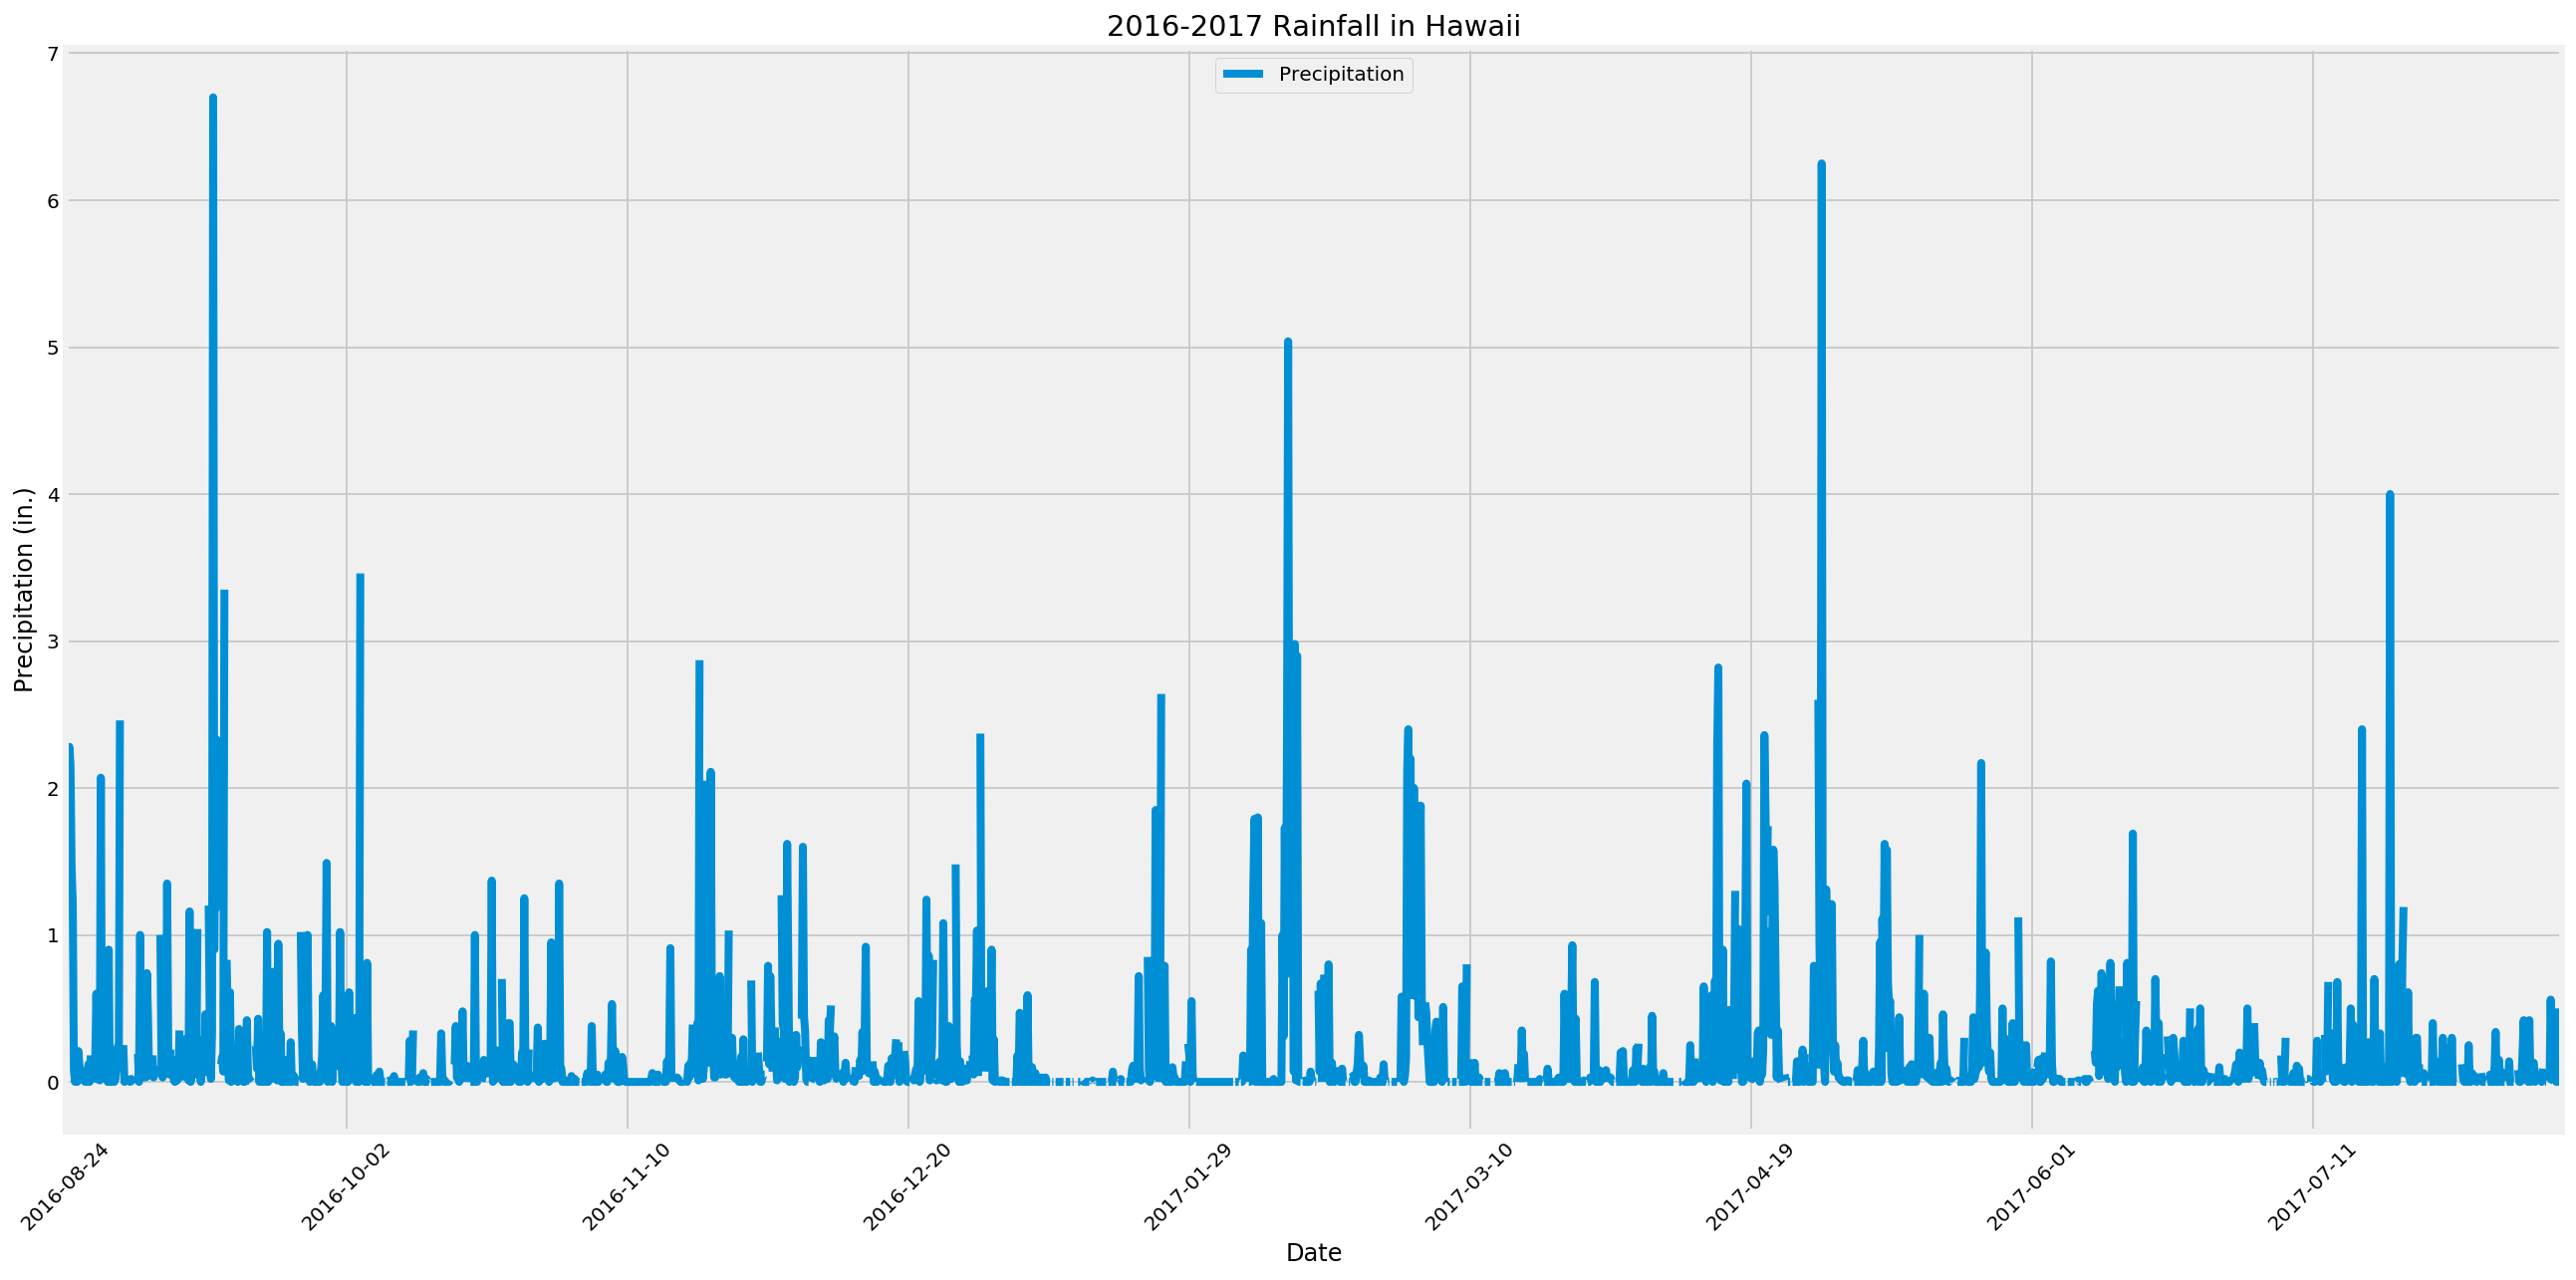

<Figure size 1440x720 with 0 Axes>

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find most recent date - data is in the form of a tuple until position is called [0]
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f'Latest Date: {latest_date}')

# Find date 12 months prior to latest_date yr-m-d
query_date = dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Query to find all dates between 8/23/16 and 8/23/17
lastyear_dates_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()
lastyear_data = pd.DataFrame(lastyear_dates_query)


# # Manipulate lastyear_data to be plotted
lastyear_data = lastyear_data.set_index('date').sort_values(by='date', ascending=True)
lastyear_data.rename(columns = {'prcp':'Precipitation'}, inplace = True) 


# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize'] = (20, 10)

lastyear_data.plot(title="2016-2017 Rainfall in Hawaii")
plt.xticks(rotation=45)
plt.ylabel("Precipitation (in.)")
plt.xlabel("Date")
plt.legend(loc='upper center')
plt.show()

plt.savefig("prcp_hi.png")

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastyear_data.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
print(station_columns)
session.query(func.count(Station.id)).all()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_df = engine.execute("SELECT * FROM station").fetchall()
stations_df = pd.DataFrame(stations_df, columns=station_columns)
stations_df = stations_df.set_index("id")
stations_df

measurement_df = engine.execute("SELECT * FROM measurement").fetchall()
measurement_df = pd.DataFrame(measurement_df, columns=measurement_columns)
measurement_df = measurement_df.set_index("id")
measurement_df

# Count stations
station_count = measurement_df.groupby("station").count().sort_values(by="date", ascending=False)
station_count = pd.DataFrame(station_count)
station_count 


,date,prcp,tobs
station,,,
USC00519281,2772,2772,2772
USC00519397,2724,2685,2724
USC00513117,2709,2696,2709
USC00519523,2669,2572,2669
USC00516128,2612,2484,2612
USC00514830,2202,1937,2202
USC00511918,1979,1932,1979
USC00517948,1372,683,1372
USC00518838,511,342,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# measurement_df = measurement_df.set_index("station")
USC00519281 = measurement_df.loc["USC00519281", :]
USC00519281

print(f"Highest temperature at USC00519281: {USC00519281.tobs.max()}F")
print(f"Lowest temperature at USC00519281: {USC00519281.tobs.min()}F")
print(f"Mean temperature at USC00519281: {USC00519281.tobs.mean()}F")


KeyError: 'USC00519281'

In [20]:

USC00519281 = USC00519281.sort_values("date", ascending=False)
USC00519281.head()

year_USC00519281 = USC00519281.iloc[0:365, :]




NameError: name 'USC00519281' is not defined

Station with most temperature data : USC00519281


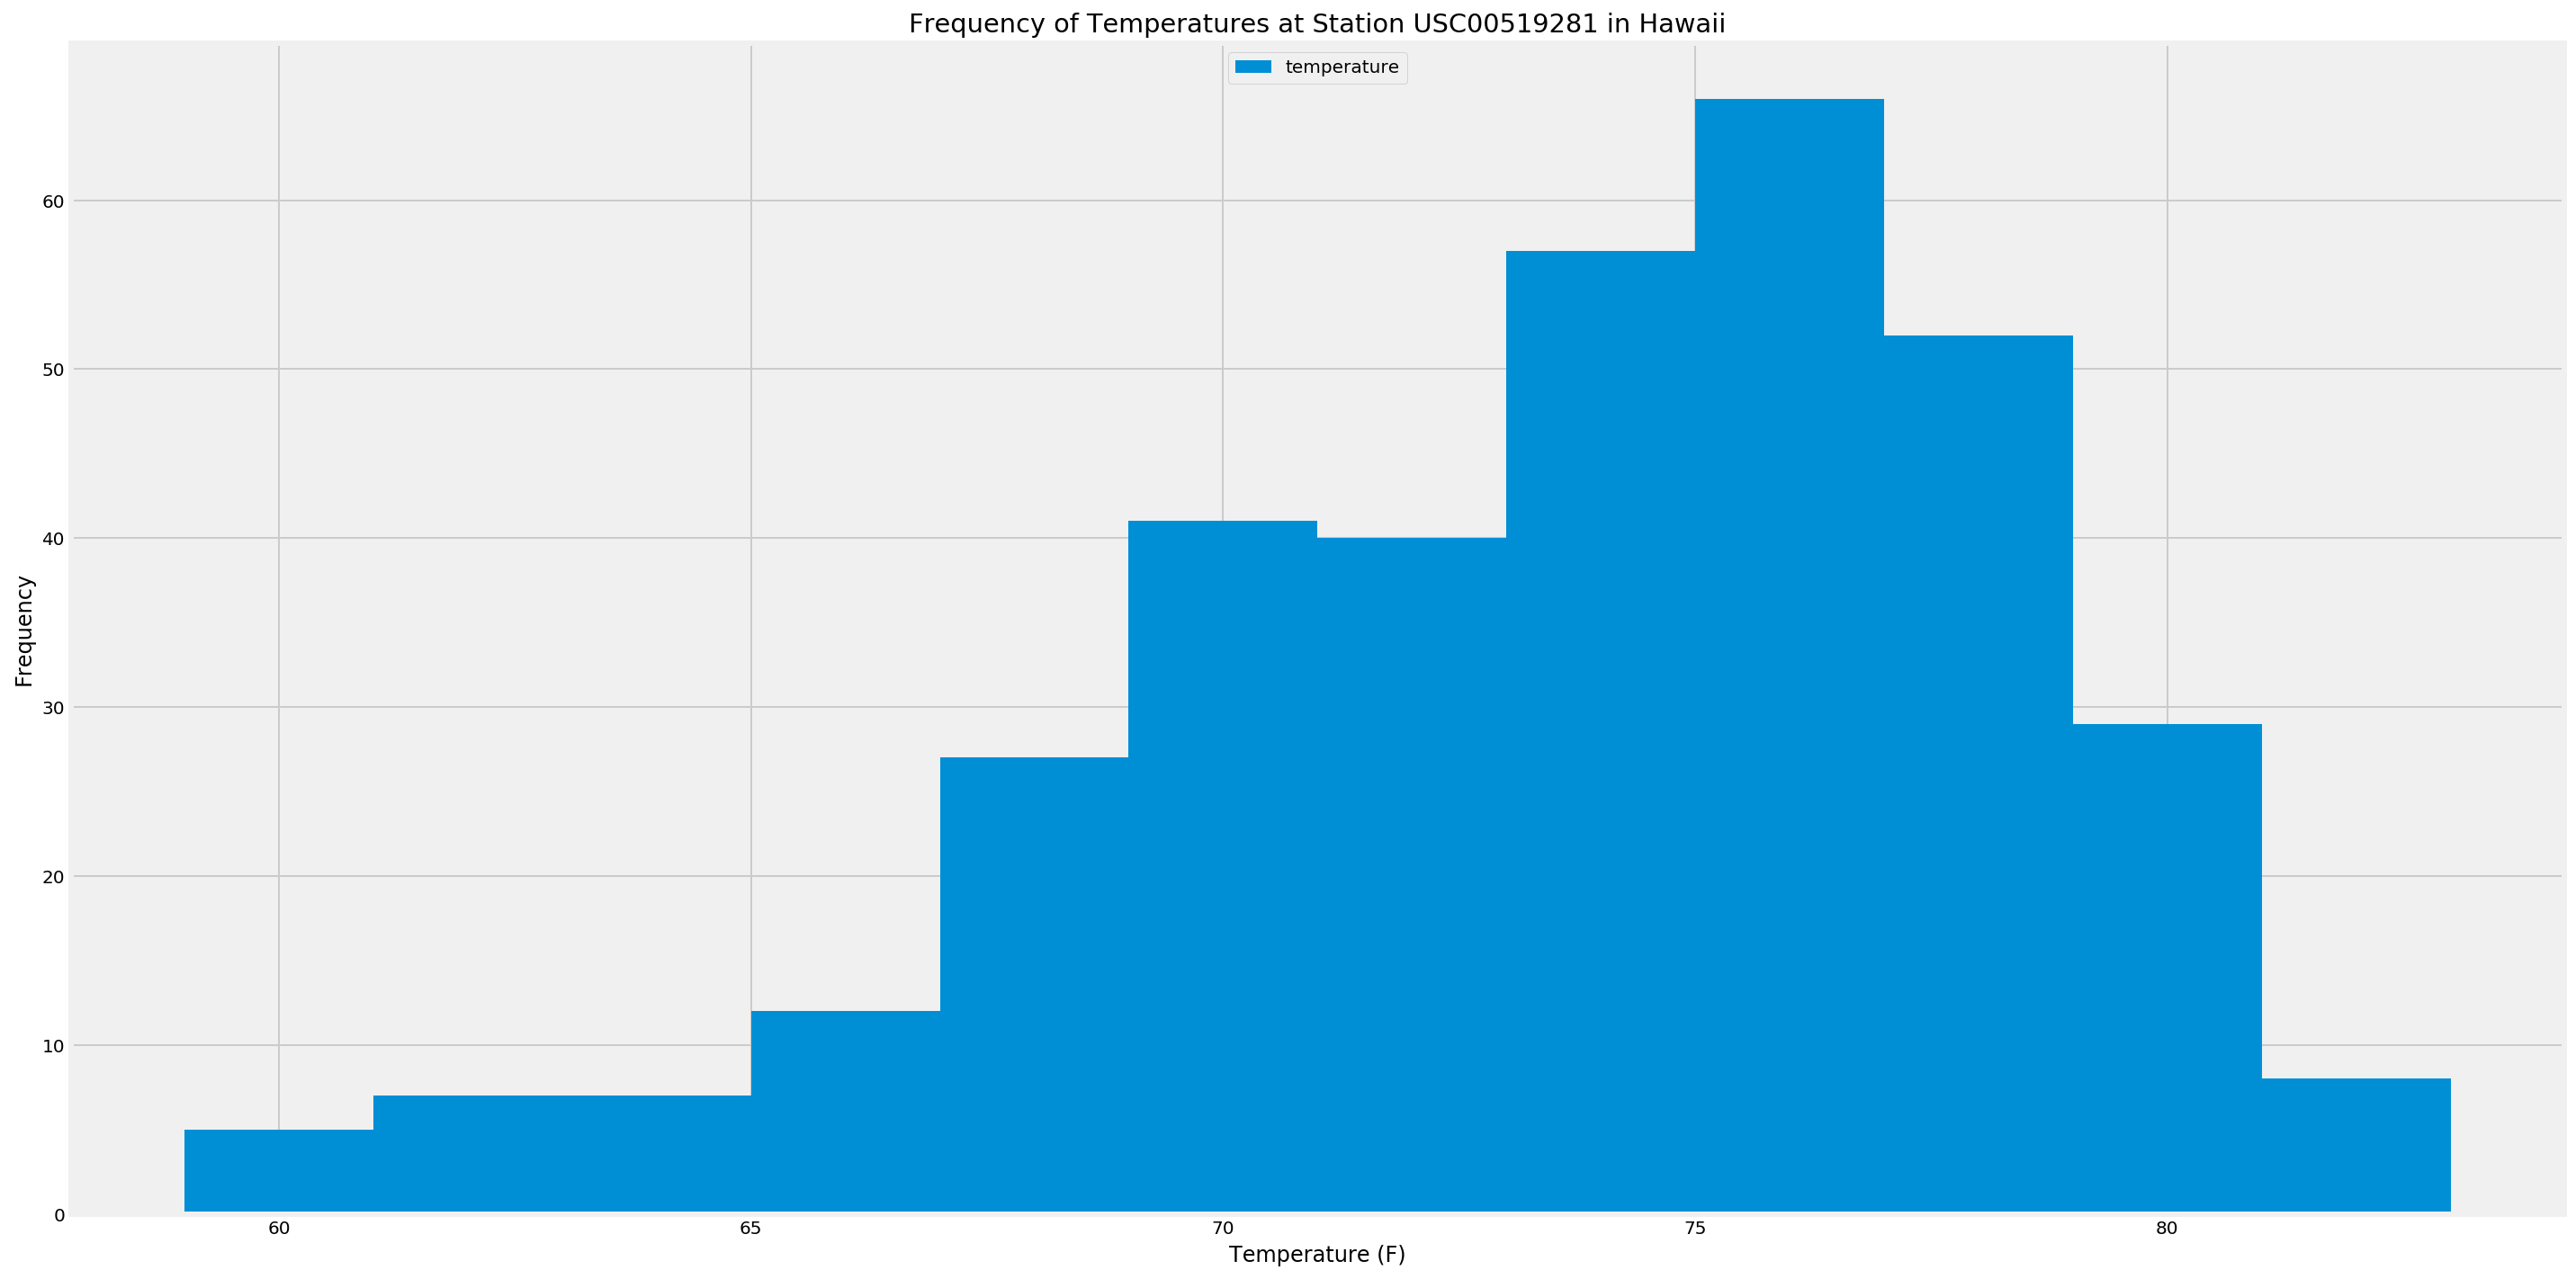

In [21]:

# Choose the station with the highest number of temperature observations.
USC00519281 = session.query(Measurement.station, func.count(Measurement.tobs))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
USC00519281 = USC00519281[0]
print(f"Station with most temperature data : {USC00519281}")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_hist = session.query( Measurement.tobs).filter(Measurement.date >= query_date)\
.filter(Measurement.station == USC00519281).all()
USC00519281_hist = pd.DataFrame(USC00519281_hist, columns=['temperature'])

# plot
USC00519281_hist.plot.hist(bins=12, title="Frequency of Temperatures at Station USC00519281 in Hawaii")
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig("temperaturehist.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-28', '2017-03-05'))
trip_avg_temp = calc_temps('2017-02-28', '2017-03-05')

[(64.0, 72.02777777777777, 78.0)]


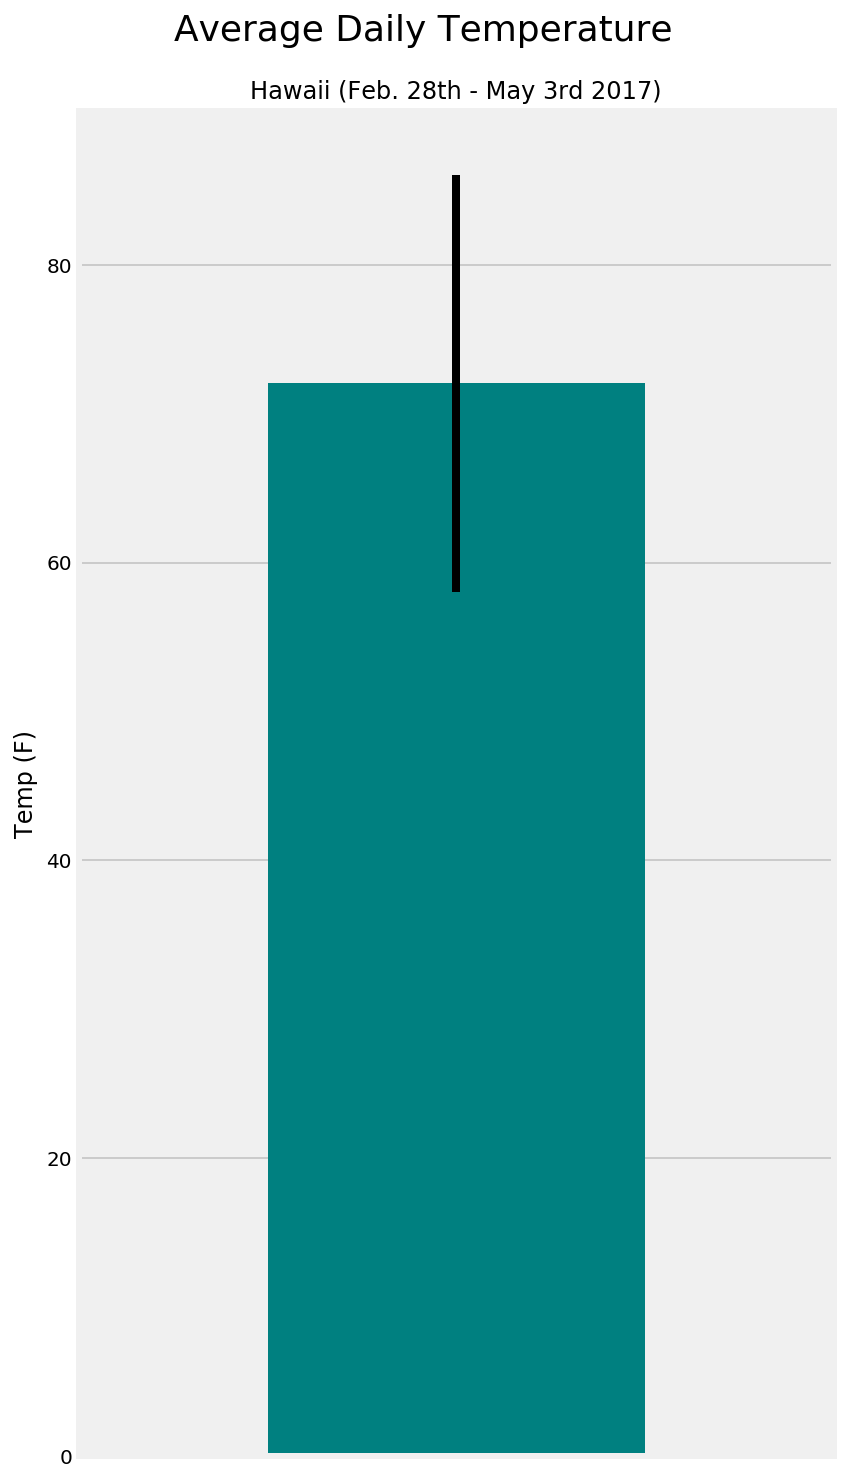

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Create a dataframe with the calculated tmin, tavg, and tmax values
trip_avg_temp = pd.DataFrame(trip_avg_temp, columns=['TMIN', 'TAV', 'TMAX'])


# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_avg_temp.plot.bar(y='TAV', yerr=(trip_avg_temp['TMAX'] - trip_avg_temp['TMIN']), color='teal', figsize=(6,10))
plt.suptitle('Average Daily Temperature', y = 1.03, fontsize = 18)
plt.title('Hawaii (Feb. 28th - May 3rd 2017)', fontsize = 12)
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.xticks([])
plt.savefig("avtripbar.png")
plt.show()

In [43]:
# Predict the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Total Rainfall per weather station

# Data grouped by weather station

# 

def prcp(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Station.name,
           Measurement.prcp,
           Measurement.station, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

rainfall_query = prcp('2017-02-28', '2017-03-05')

rainfall_query = pd.DataFrame(rainfall_query)
rainfall_query

,name,prcp,station,latitude,longitude,elevation
0,"MANOA LYON ARBO 785.2, HI US",0.58,USC00516128,21.33310,-157.80250,152.4
1,"KANEOHE 838.1, HI US",0.16,USC00513117,21.42340,-157.80150,14.6
2,"WAIHEE 837.5, HI US",0.04,USC00519281,21.45167,-157.84889,32.9
3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.04,USC00514830,21.52130,-157.83740,7.0
4,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,USC00519523,21.33556,-157.71139,19.5
5,"WAIKIKI 717.2, HI US",0.00,USC00519397,21.27160,-157.81680,3.0
6,"PEARL CITY, HI US",NaN,USC00517948,21.39340,-157.97510,11.9
